In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from copy import deepcopy

from qiskit import IBMQ, pulse, schedule, transpile, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.pulse import pulse_lib as pulse_library, reschedule
from qiskit.ignis.measurement.discriminator.iq_discriminators import LinearIQDiscriminator
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter
import qiskit.ignis.mitigation.measurement as mit
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography.basis import PauliBasis
from qiskit.visualization.state_visualization import plot_state_city
from qiskit.quantum_info import state_fidelity
from qiskit.circuit import Gate
from qiskit.scheduler import schedule_circuit, ScheduleConfig

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [35]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
config = backend.configuration()
props = backend.properties()

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


## XGate Process Tomography

We study the fidelity of an X process, implemented through an odd number of repetitions of the X gate.
The X gate is done with 2 pulses (a standard U3 implementation), or 1 pulse (an optimized implementation).

### experiment parameters

In [166]:
def qubit_t1(qubit):
    return props.qubits[qubit][0].value

def qubit_t2(qubit):
    return props.qubits[qubit][1].value

def sort_qubits_by_t1():
    """in ascending order"""
    qubits = [i for i in range(config.n_qubits)]
    qubits = sorted(qubits, key=qubit_t1)
    return qubits

In [167]:
sort_qubits_by_t1()

[7, 1, 6, 16, 11, 12, 3, 8, 15, 18, 5, 9, 10, 13, 2, 0, 17, 4, 19, 14]

In [174]:
qubit = sort_qubits_by_t1()[0]  # which qubit to study
reps = 21                       # how many repetitions of the x gate
shots = 1000

### set up process tomography

In [4]:
# create the process tomography circuits
# create a new 'repx' gate which will we later add to the 
# cmd_def
num_qubits = 1
qr = QuantumRegister(num_qubits)
my_gate = Gate(name='repx', num_qubits=num_qubits, params=[])

# create the tomography circuits
qc = QuantumCircuit(qr)
qc.append(my_gate, qr[:])
qpt_qcs = process_tomography_circuits(qc, measured_qubits=qr)
# transpile so that the singles are in terms of the u gates
qpt_qcs2 = transpile(qpt_qcs, backend, basis_gates=['u1','u2','u3'], optimization_level=0)

# create the measurement circuits
meas_circs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])

# combine
qst_plus_meas = meas_circs + qst_qcs2

# add the zx90 gate to the cmd def from the cx definition
cx_schedule = cmd_def.get('cx', qubits=[0,1])
cmd_def.add("zx90", qubits=[0,1], schedule=pulse.Schedule(cx_schedule.instructions[4]))

# schedule!
schedule_config = ScheduleConfig(cmd_def, meas_map=backend.configuration().meas_map)
qst_schedules = [schedule_circuit(qcirc, schedule_config) for qcirc in qst_plus_meas]

AttributeError: 'int' object has no attribute 'register'

In [175]:
# Standard X gate
circuit = q.QuantumCircuit(1)
# standard X gate is U3(pi, 0, pi)
schedule = q.pulse.Schedule()
x_sched = cmd_def.get('u3', qubits=[qubit], P0=np.pi, P1=0, P2=np.pi)
for _ in range(reps):
    schedule |= x_sched << schedule.duration
#measure = cmd_def.get('measure', qubits=config.meas_map[0])
#schedule |= measure << schedule.duration

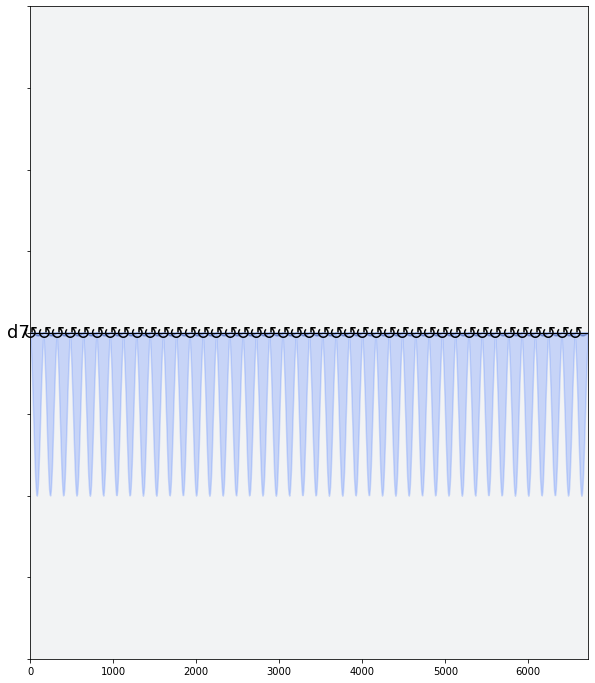

In [185]:
schedule.draw(channels=[config.drive(qubit)], table=False)

In [179]:
# Our way
circuit = q.QuantumCircuit(20)
for _ in range(reps):
    circuit.x(qubit)

decomposed_circuit = circuit.decompose()

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)

schedule_opt = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
measure = cmd_def.get('measure', qubits=config.meas_map[0])
schedule_opt |= measure << schedule_opt.duration

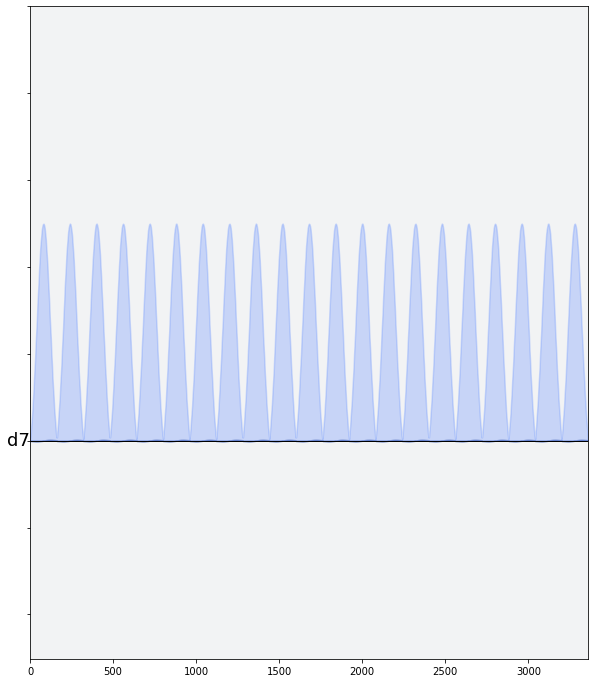

In [180]:
schedule_opt.draw(channels=[config.drive(qubit)])

### Coherence limit error
What is the best error we can hope for from the gates?

In [181]:
from qiskit.ignis.verification.randomized_benchmarking.rb_utils import coherence_limit

t1 = qubit_t1(qubit)
t2 = qubit_t2(qubit)

u3_duration = schedule.ch_duration(config.drive(qubit))*config.dt*1e6  # in us
u3_error_limit = coherence_limit(nQ=1, T1_list=[t1], T2_list=[t2], gatelen=reps*u3_duration)
print('{0} ns: {1}% fidelity'.format(u3_duration*1000, 1 - u3_error_limit))

x_duration = schedule_opt.ch_duration(config.drive(qubit))*config.dt*1e6  # in us
x_error_limit = coherence_limit(nQ=1, T1_list=[t1], T2_list=[t2], gatelen=reps*x_duration)
print('{0} ns: {1}% fidelity'.format(x_duration*1000, 1 - x_error_limit))

1493.3333333333335 ns: 0.5960506125973739% fidelity
746.6666666666667 ns: 0.7170668304495524% fidelity


### Experimental error
Get fidelity of execution.

In [182]:
job = q.execute([schedule, schedule_opt], backend)

/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [186]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [164]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=0, status_msg='active')

In [189]:
from qiskit.ignis.verification.tomography.data import marginal_counts
result = job.result()
counts0 = marginal_counts(result.get_counts(0), [qubit+1])
counts1 = marginal_counts(result.get_counts(1), [qubit+1])
print(counts0)
print(counts1)

{'0': 107, '1': 917}
{'0': 99, '1': 925}


## Direct RX(theta) Gate

In [ ]:
# rx(pi/8) gate
circuit = q.QuantumCircuit(1)
# standard rx(pi/8) gate decomposition is U3(pi/8, -pi/2, pi/2)
schedule = cmd_def.get('u3', qubits=[0], P0=np.pi/8, P1=-np.pi/2, P2=np.pi/2)
schedule = q.pulse.SamplePulse([0.1])(config.drive(0)) + schedule  # to set a standard scale
schedule.draw(channels_to_plot=[config.drive(0)])

In [ ]:
# Our way
circuit = q.QuantumCircuit(1)
circuit.rx(np.pi/8, 0)
print(circuit)

decomposed_circuit = circuit.decompose()
print(decomposed_circuit)

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
print(transpiled_circuit)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule = q.pulse.SamplePulse([0.1])(config.drive(0)) + schedule  # to set a standard scale
schedule.draw(channels_to_plot=[system.qubits[0].drive])

In [199]:
from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector()

TypeError: plot_bloch_multivector() missing 1 required positional argument: 'rho'

In [201]:
from qiskit import execute

In [ ]:
execute(circuit, backend)